In [ ]:
#%%

import tensorflow as tf
import tf_keras
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tf_keras import layers
from tf_keras.models import Sequential
from sklearn.metrics import confusion_matrix
from tf_keras.optimizers import Adam
from tf_keras.regularizers import l2

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
  tf.config.experimental.set_memory_growth(gpu_devices[0], True)
  print('GPU found', gpu_devices[0])
else:
  print('No GPU found')

#define image size
IMG_SIZE = 224

#define batch size
BATCH_SIZE = 64

#training directory
TRAINING_DIR = "Train"
  
#training split
train_ds = tf_keras.utils.image_dataset_from_directory(
  TRAINING_DIR,
  labels = "inferred",
  image_size = (IMG_SIZE, IMG_SIZE),
  batch_size = BATCH_SIZE,
  subset = "training",
  validation_split = 0.25,
  shuffle = True,
  seed = 225
)

#validation split, taken directly from the same directory as train
validation_ds = tf_keras.utils.image_dataset_from_directory(
  TRAINING_DIR,
  labels = "inferred",
  image_size = (IMG_SIZE, IMG_SIZE),
  batch_size = BATCH_SIZE,
  subset = 'validation',
  validation_split = 0.25,
  shuffle = True,
  seed = 225
)

CLASS_NAMES = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

#data augmentation to increase robustness
data_augmentation = Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2) 
])

#normalizing and augmenting the data
norm_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (norm_layer(data_augmentation(x)), y))
validation_ds = validation_ds.map(lambda x, y: (norm_layer(x), y))

num_classes = len(CLASS_NAMES)

#training model
model = Sequential([
  layers.Conv2D(128, (3, 3), input_shape = (224, 224, 3)),
  layers.BatchNormalization(),  
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(128, (3, 3)),
  layers.BatchNormalization(),  
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(256, (3, 3)),
  layers.BatchNormalization(),  
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(256, (3, 3)),
  layers.BatchNormalization(),  
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(512, (5, 5)),
  layers.BatchNormalization(),  
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(512, (3, 3)),
  layers.BatchNormalization(),  
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Flatten(),
  layers.Dense(1024, activation = 'relu', kernel_regularizer = l2(0.02)),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation = 'softmax')
])

model.summary()

model.compile(optimizer = Adam(learning_rate = 0.0005, weight_decay = 1e-6), 
              loss = tf_keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
              metrics = ['accuracy'])

#no of epochs
epochs = 10


#early stopping
early_stopping = tf_keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  mode = 'min', 
                                                  verbose = 1, 
                                                  patience = 7, 
                                                  restore_best_weights = True)

#class weights since the dataset is imbalanced
class_weights = {
    0: 0.657,  #bike
    1: 1.165,  #bus
    2: 1.006,  #cng
    3: 0.885,  #easy bike
    4: 1.385,  #hatchback
    5: 1.296,  #mpv
    6: 2.689,  #pickup
    7: 0.695,  #sedan
    8: 1.117,  #suv
    9: 0.770   #truck
}


#fitting of the model
history = model.fit(train_ds, 
                    validation_data = validation_ds, 
                    epochs = epochs,
                    class_weight = class_weights, 
                    callbacks = [early_stopping])

#accuracy and loss values
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

true_labels = []
predicted_labels = []

for images, labels in val_ds:
  true_labels.extend(labels.numpy())
  pred = model.predict(images)
  predicted_labels.extend(np.argmax(pred, axis = 1))

confusion_matrix = confusion_matrix(true_labels, predicted_labels)

print('Confusion Matrix: ')
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot = True, fmt = 'd', xticklabels = CLASS_NAMES, yticklabels = CLASS_NAMES, cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

score = model.evaluate(validation_ds, verbose = 0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

2025-01-20 00:25:12.272387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737325512.286932  189616 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737325512.291345  189616 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 00:25:12.306145: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU found PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found 6480 files belonging to 10 classes.
Using 4860 files for training.


I0000 00:00:1737325514.824790  189616 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4662 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


Found 6480 files belonging to 10 classes.
Using 1620 files for validation.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 batch_normalization (Batch  (None, 222, 222, 128)     512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 222, 222, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     147584    
                                             

/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1737325523.127190  189681 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-20 00:25:24.190325: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 387.28MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
W0000 00:00:1737325524.190350  189681 gpu_utils.cc:68] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
20

ResourceExhaustedError: Graph execution error:

Detected at node sequential_1/batch_normalization_1/FusedBatchNormV3 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/tmp/ipykernel_189616/900042053.py", line 29, in wrapper

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "<ipython-input-1-c9b743688254>", line 138, in <module>

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1804, in fit

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1398, in train_function

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1381, in step_function

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1370, in run_step

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1147, in train_step

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 588, in __call__

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/sequential.py", line 397, in call

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/functional.py", line 514, in call

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/functional.py", line 671, in _run_internal_graph

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/layers/normalization/batch_normalization.py", line 597, in call

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/layers/normalization/batch_normalization.py", line 990, in _fused_batch_norm

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/utils/control_flow_util.py", line 108, in smart_cond

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/layers/normalization/batch_normalization.py", line 964, in _fused_batch_norm_training

OOM when allocating tensor with shape[64,128,109,109] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_1/batch_normalization_1/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_4590]

In [ ]:
#%%

import tensorflow as tf
import tf_keras
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tf_keras import layers
from tf_keras.models import Sequential
from sklearn.metrics import confusion_matrix
from tf_keras.optimizers import Adam
from tf_keras.regularizers import l2

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
  tf.config.experimental.set_memory_growth(gpu_devices[0], True)
  print('GPU found', gpu_devices[0])
else:
  print('No GPU found')

#define image size
IMG_SIZE = 224

#define batch size
BATCH_SIZE = 64

#training directory
TRAINING_DIR = "Train"
  
#training split
train_ds = tf_keras.utils.image_dataset_from_directory(
  TRAINING_DIR,
  labels = "inferred",
  image_size = (IMG_SIZE, IMG_SIZE),
  batch_size = BATCH_SIZE,
  subset = "training",
  validation_split = 0.25,
  shuffle = True,
  seed = 225
)

#validation split, taken directly from the same directory as train
validation_ds = tf_keras.utils.image_dataset_from_directory(
  TRAINING_DIR,
  labels = "inferred",
  image_size = (IMG_SIZE, IMG_SIZE),
  batch_size = BATCH_SIZE,
  subset = 'validation',
  validation_split = 0.25,
  shuffle = True,
  seed = 225
)

CLASS_NAMES = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

#data augmentation to increase robustness
data_augmentation = Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2) 
])

#normalizing and augmenting the data
norm_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (norm_layer(data_augmentation(x)), y))
validation_ds = validation_ds.map(lambda x, y: (norm_layer(x), y))

num_classes = len(CLASS_NAMES)

#training model
model = Sequential([
  layers.Conv2D(128, (3, 3), input_shape = (224, 224, 3)),
  layers.BatchNormalization(),  
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(128, (3, 3)),
  layers.BatchNormalization(),  
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(256, (3, 3)),
  layers.BatchNormalization(),  
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(256, (3, 3)),
  layers.BatchNormalization(),  
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(512, (5, 5)),
  layers.BatchNormalization(),  
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(512, (3, 3)),
  layers.BatchNormalization(),  
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Flatten(),
  layers.Dense(1024, activation = 'relu', kernel_regularizer = l2(0.02)),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation = 'softmax')
])

model.summary()

model.compile(optimizer = Adam(learning_rate = 0.0005, weight_decay = 1e-6), 
              loss = tf_keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
              metrics = ['accuracy'])

#no of epochs
epochs = 10


#early stopping
early_stopping = tf_keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  mode = 'min', 
                                                  verbose = 1, 
                                                  patience = 3, 
                                                  restore_best_weights = True)

#class weights since the dataset is imbalanced
class_weights = {
    0: 0.657,  #bike
    1: 1.165,  #bus
    2: 1.006,  #cng
    3: 0.885,  #easy bike
    4: 1.385,  #hatchback
    5: 1.296,  #mpv
    6: 2.689,  #pickup
    7: 0.695,  #sedan
    8: 1.117,  #suv
    9: 0.770   #truck
}


#fitting of the model
history = model.fit(train_ds, 
                    validation_data = validation_ds, 
                    epochs = epochs,
                    class_weight = class_weights, 
                    callbacks = [early_stopping])

#accuracy and loss values
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

true_labels = []
predicted_labels = []

for images, labels in val_ds:
  true_labels.extend(labels.numpy())
  pred = model.predict(images)
  predicted_labels.extend(np.argmax(pred, axis = 1))

confusion_matrix = confusion_matrix(true_labels, predicted_labels)

print('Confusion Matrix: ')
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot = True, fmt = 'd', xticklabels = CLASS_NAMES, yticklabels = CLASS_NAMES, cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

score = model.evaluate(validation_ds, verbose = 0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

GPU found PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found 6480 files belonging to 10 classes.
Using 4860 files for training.
Found 6480 files belonging to 10 classes.
Using 1620 files for validation.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 128)     3584      
                                                                 
 batch_normalization_6 (Bat  (None, 222, 222, 128)     512       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 222, 222, 128)     0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 128)     0         
 g2D)                                                            
                             

2025-01-20 00:26:15.417851: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 371.28MiB (rounded to 389316608)requested by op sequential_3/batch_normalization_7/FusedBatchNormV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-01-20 00:26:15.417883: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1053] BFCAllocator dump for GPU_0_bfc
2025-01-20 00:26:15.417891: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (256): 	Total Chunks: 78, Chunks in use: 76. 19.5KiB allocated for chunks. 19.0KiB in use in bin. 1.3KiB client-requested in use in bin.
2025-01-20 00:26:15.417897: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (512): 	Total Chunks: 51, Chunks in use: 50. 26.0KiB allocated for chunks. 25.5KiB in use in bin. 2

ResourceExhaustedError: Graph execution error:

Detected at node sequential_3/batch_normalization_7/FusedBatchNormV3 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/tmp/ipykernel_189616/900042053.py", line 29, in wrapper

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "<ipython-input-2-4cd8e1f7d30e>", line 138, in <module>

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1804, in fit

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1398, in train_function

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1381, in step_function

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1370, in run_step

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1147, in train_step

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 588, in __call__

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/sequential.py", line 397, in call

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/functional.py", line 514, in call

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/functional.py", line 671, in _run_internal_graph

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/layers/normalization/batch_normalization.py", line 597, in call

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/layers/normalization/batch_normalization.py", line 990, in _fused_batch_norm

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/utils/control_flow_util.py", line 108, in smart_cond

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/layers/normalization/batch_normalization.py", line 964, in _fused_batch_norm_training

OOM when allocating tensor with shape[64,128,109,109] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_3/batch_normalization_7/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_9179]

In [ ]:
#%%

import tensorflow as tf
import tf_keras
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tf_keras import layers
from tf_keras.models import Sequential
from sklearn.metrics import confusion_matrix
from tf_keras.optimizers import Adam
from tf_keras.regularizers import l2

tf.keras.backend.clear_session()

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
  tf.config.experimental.set_memory_growth(gpu_devices[0], True)
  print('GPU found', gpu_devices[0])
else:
  print('No GPU found')

#define image size
IMG_SIZE = 224

#define batch size
BATCH_SIZE = 64

#training directory
TRAINING_DIR = "Train"
  
#training split
train_ds = tf_keras.utils.image_dataset_from_directory(
  TRAINING_DIR,
  labels = "inferred",
  image_size = (IMG_SIZE, IMG_SIZE),
  batch_size = BATCH_SIZE,
  subset = "training",
  validation_split = 0.25,
  shuffle = True,
  seed = 225
)

#validation split, taken directly from the same directory as train
validation_ds = tf_keras.utils.image_dataset_from_directory(
  TRAINING_DIR,
  labels = "inferred",
  image_size = (IMG_SIZE, IMG_SIZE),
  batch_size = BATCH_SIZE,
  subset = 'validation',
  validation_split = 0.25,
  shuffle = True,
  seed = 225
)

CLASS_NAMES = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

#data augmentation to increase robustness
data_augmentation = Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2) 
])

#normalizing and augmenting the data
norm_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (norm_layer(data_augmentation(x)), y))
validation_ds = validation_ds.map(lambda x, y: (norm_layer(x), y))

num_classes = len(CLASS_NAMES)

#training model
model = Sequential([
  layers.Conv2D(128, (3, 3), input_shape = (224, 224, 3)),
  layers.BatchNormalization(),  
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(128, (3, 3)),
  layers.BatchNormalization(),  
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(256, (3, 3)),
  layers.BatchNormalization(),  
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(256, (3, 3)),
  layers.BatchNormalization(),  
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(512, (5, 5)),
  layers.BatchNormalization(),  
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(512, (3, 3)),
  layers.BatchNormalization(),  
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Flatten(),
  layers.Dense(1024, activation = 'relu', kernel_regularizer = l2(0.02)),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation = 'softmax')
])

model.summary()

model.compile(optimizer = Adam(learning_rate = 0.0005, weight_decay = 1e-6), 
              loss = tf_keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
              metrics = ['accuracy'])

#no of epochs
epochs = 10


#early stopping
early_stopping = tf_keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  mode = 'min', 
                                                  verbose = 1, 
                                                  patience = 3, 
                                                  restore_best_weights = True)

#class weights since the dataset is imbalanced
class_weights = {
    0: 0.657,  #bike
    1: 1.165,  #bus
    2: 1.006,  #cng
    3: 0.885,  #easy bike
    4: 1.385,  #hatchback
    5: 1.296,  #mpv
    6: 2.689,  #pickup
    7: 0.695,  #sedan
    8: 1.117,  #suv
    9: 0.770   #truck
}


#fitting of the model
history = model.fit(train_ds, 
                    validation_data = validation_ds, 
                    epochs = epochs,
                    class_weight = class_weights, 
                    callbacks = [early_stopping])

#accuracy and loss values
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

true_labels = []
predicted_labels = []

for images, labels in val_ds:
  true_labels.extend(labels.numpy())
  pred = model.predict(images)
  predicted_labels.extend(np.argmax(pred, axis = 1))

confusion_matrix = confusion_matrix(true_labels, predicted_labels)

print('Confusion Matrix: ')
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot = True, fmt = 'd', xticklabels = CLASS_NAMES, yticklabels = CLASS_NAMES, cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

score = model.evaluate(validation_ds, verbose = 0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

GPU found PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found 6480 files belonging to 10 classes.
Using 4860 files for training.
Found 6480 files belonging to 10 classes.
Using 1620 files for validation.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 batch_normalization (Batch  (None, 222, 222, 128)     512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 222, 222, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 128)     0         
 D)                                                              
                             

2025-01-20 00:27:44.962319: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 371.28MiB (rounded to 389316608)requested by op sequential_1/batch_normalization_1/FusedBatchNormV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-01-20 00:27:44.962351: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1053] BFCAllocator dump for GPU_0_bfc
2025-01-20 00:27:44.962360: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (256): 	Total Chunks: 77, Chunks in use: 75. 19.2KiB allocated for chunks. 18.8KiB in use in bin. 1.4KiB client-requested in use in bin.
2025-01-20 00:27:44.962366: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (512): 	Total Chunks: 74, Chunks in use: 72. 37.5KiB allocated for chunks. 36.5KiB in use in bin. 3

ResourceExhaustedError: Graph execution error:

Detected at node sequential_1/batch_normalization_1/FusedBatchNormV3 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/tmp/ipykernel_189616/900042053.py", line 29, in wrapper

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "<ipython-input-3-108f94a06fa4>", line 140, in <module>

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1804, in fit

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1398, in train_function

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1381, in step_function

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1370, in run_step

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1147, in train_step

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 588, in __call__

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/sequential.py", line 397, in call

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/functional.py", line 514, in call

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/functional.py", line 671, in _run_internal_graph

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/layers/normalization/batch_normalization.py", line 597, in call

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/layers/normalization/batch_normalization.py", line 990, in _fused_batch_norm

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/utils/control_flow_util.py", line 108, in smart_cond

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/layers/normalization/batch_normalization.py", line 964, in _fused_batch_norm_training

OOM when allocating tensor with shape[64,128,109,109] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_1/batch_normalization_1/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_13769]

In [ ]:
#%%

import tensorflow as tf
import tf_keras
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tf_keras import layers
from tf_keras.models import Sequential
from sklearn.metrics import confusion_matrix
from tf_keras.optimizers import Adam
from tf_keras.regularizers import l2

tf.keras.backend.clear_session()

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
  tf.config.experimental.set_memory_growth(gpu_devices[0], True)
  print('GPU found', gpu_devices[0])
else:
  print('No GPU found')

#define image size
IMG_SIZE = 224

#define batch size
BATCH_SIZE = 64

#training directory
TRAINING_DIR = "Train"
  
#training split
train_ds = tf_keras.utils.image_dataset_from_directory(
  TRAINING_DIR,
  labels = "inferred",
  image_size = (IMG_SIZE, IMG_SIZE),
  batch_size = BATCH_SIZE,
  subset = "training",
  validation_split = 0.25,
  shuffle = True,
  seed = 225
)

#validation split, taken directly from the same directory as train
validation_ds = tf_keras.utils.image_dataset_from_directory(
  TRAINING_DIR,
  labels = "inferred",
  image_size = (IMG_SIZE, IMG_SIZE),
  batch_size = BATCH_SIZE,
  subset = 'validation',
  validation_split = 0.25,
  shuffle = True,
  seed = 225
)

CLASS_NAMES = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

#data augmentation to increase robustness
data_augmentation = Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2) 
])

#normalizing and augmenting the data
norm_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (norm_layer(data_augmentation(x)), y))
validation_ds = validation_ds.map(lambda x, y: (norm_layer(x), y))

num_classes = len(CLASS_NAMES)

#training model
model = Sequential([
  layers.Conv2D(128, (3, 3), input_shape = (224, 224, 3)),
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(128, (3, 3)),
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(256, (3, 3)),
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(256, (3, 3)),
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(512, (5, 5)), 
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(512, (3, 3)),
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Flatten(),
  layers.Dense(1024, activation = 'relu', kernel_regularizer = l2(0.02)),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation = 'softmax')
])

model.summary()

model.compile(optimizer = Adam(learning_rate = 0.0005, weight_decay = 1e-6), 
              loss = tf_keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
              metrics = ['accuracy'])

#no of epochs
epochs = 10


#early stopping
early_stopping = tf_keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  mode = 'min', 
                                                  verbose = 1, 
                                                  patience = 3, 
                                                  restore_best_weights = True)

#class weights since the dataset is imbalanced
class_weights = {
    0: 0.657,  #bike
    1: 1.165,  #bus
    2: 1.006,  #cng
    3: 0.885,  #easy bike
    4: 1.385,  #hatchback
    5: 1.296,  #mpv
    6: 2.689,  #pickup
    7: 0.695,  #sedan
    8: 1.117,  #suv
    9: 0.770   #truck
}


#fitting of the model
history = model.fit(train_ds, 
                    validation_data = validation_ds, 
                    epochs = epochs,
                    class_weight = class_weights, 
                    callbacks = [early_stopping])

#accuracy and loss values
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

true_labels = []
predicted_labels = []

for images, labels in val_ds:
  true_labels.extend(labels.numpy())
  pred = model.predict(images)
  predicted_labels.extend(np.argmax(pred, axis = 1))

confusion_matrix = confusion_matrix(true_labels, predicted_labels)

print('Confusion Matrix: ')
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot = True, fmt = 'd', xticklabels = CLASS_NAMES, yticklabels = CLASS_NAMES, cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

score = model.evaluate(validation_ds, verbose = 0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

GPU found PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found 6480 files belonging to 10 classes.
Using 4860 files for training.
Found 6480 files belonging to 10 classes.
Using 1620 files for validation.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 activation (Activation)     (None, 222, 222, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     147584    
                                                                 
 activation_1 (Activation)   

2025-01-20 00:28:13.326793: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-20 00:28:14.249738: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-20 00:28:14.436793: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-20 00:28:14.436867: W external/local_xla/xla/ts

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/sequential_1/max_pooling2d/MaxPool/MaxPoolGrad defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/tmp/ipykernel_189616/900042053.py", line 29, in wrapper

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "<ipython-input-4-827581537b80>", line 134, in <module>

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1804, in fit

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1398, in train_function

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1381, in step_function

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1370, in run_step

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1151, in train_step

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/optimizers/optimizer.py", line 622, in minimize

  File "/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/optimizers/optimizer.py", line 280, in compute_gradients

OOM when allocating tensor with shape[64,128,222,222] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_1/max_pooling2d/MaxPool/MaxPoolGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_16895]

GPU found PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found 6480 files belonging to 10 classes.
Using 4860 files for training.
Found 6480 files belonging to 10 classes.
Using 1620 files for validation.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 activation (Activation)     (None, 222, 222, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 activation_1 (Activation)   

2025-01-20 00:30:03.041179: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


76/76 [==============================] - 67s 751ms/step - loss: 6.1140 - accuracy: 0.1424 - val_loss: 3.9847 - val_accuracy: 0.1475
Epoch 2/10
58/76 [=====================>........] - ETA: 10s - loss: 3.3065 - accuracy: 0.1700

2025-01-20 00:31:05.908549: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


76/76 [==============================] - 59s 717ms/step - loss: 3.1723 - accuracy: 0.1632 - val_loss: 2.5920 - val_accuracy: 0.1852
Epoch 3/10
58/76 [=====================>........] - ETA: 10s - loss: 2.4389 - accuracy: 0.2042

2025-01-20 00:32:05.655819: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


76/76 [==============================] - 60s 735ms/step - loss: 2.4041 - accuracy: 0.2049 - val_loss: 2.1992 - val_accuracy: 0.2216
Epoch 4/10
58/76 [=====================>........] - ETA: 10s - loss: 2.1777 - accuracy: 0.2330

2025-01-20 00:33:06.604707: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


76/76 [==============================] - 60s 737ms/step - loss: 2.1686 - accuracy: 0.2350 - val_loss: 2.0120 - val_accuracy: 0.2623
Epoch 5/10
58/76 [=====================>........] - ETA: 9s - loss: 2.0551 - accuracy: 0.2640 

2025-01-20 00:34:03.353890: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


76/76 [==============================] - 57s 690ms/step - loss: 2.0457 - accuracy: 0.2716 - val_loss: 1.9615 - val_accuracy: 0.3154
Epoch 6/10
58/76 [=====================>........] - ETA: 9s - loss: 1.9580 - accuracy: 0.3225 

2025-01-20 00:35:01.470845: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


76/76 [==============================] - 58s 701ms/step - loss: 1.9476 - accuracy: 0.3263 - val_loss: 1.7991 - val_accuracy: 0.3802
Epoch 7/10
58/76 [=====================>........] - ETA: 10s - loss: 1.8921 - accuracy: 0.3343

2025-01-20 00:36:00.154644: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


76/76 [==============================] - 60s 735ms/step - loss: 1.8859 - accuracy: 0.3412 - val_loss: 1.7740 - val_accuracy: 0.3889
Epoch 8/10
58/76 [=====================>........] - ETA: 10s - loss: 1.8186 - accuracy: 0.3807

2025-01-20 00:36:59.982725: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


76/76 [==============================] - 59s 724ms/step - loss: 1.8120 - accuracy: 0.3848 - val_loss: 1.7251 - val_accuracy: 0.4043
Epoch 9/10
58/76 [=====================>........] - ETA: 10s - loss: 1.7776 - accuracy: 0.3928

2025-01-20 00:37:58.927907: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


76/76 [==============================] - 60s 734ms/step - loss: 1.7801 - accuracy: 0.3918 - val_loss: 1.6384 - val_accuracy: 0.4327
Epoch 10/10
58/76 [=====================>........] - ETA: 9s - loss: 1.7346 - accuracy: 0.4189 

2025-01-20 00:38:57.741072: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


76/76 [==============================] - 57s 693ms/step - loss: 1.7245 - accuracy: 0.4204 - val_loss: 1.8270 - val_accuracy: 0.3901
Restoring model weights from the end of the best epoch: 9.
1/1 [==============================] - 0s 67ms/step
Confusion Matrix: 
Validation loss: 1.6383885145187378
Validation accuracy: 0.43271604180336


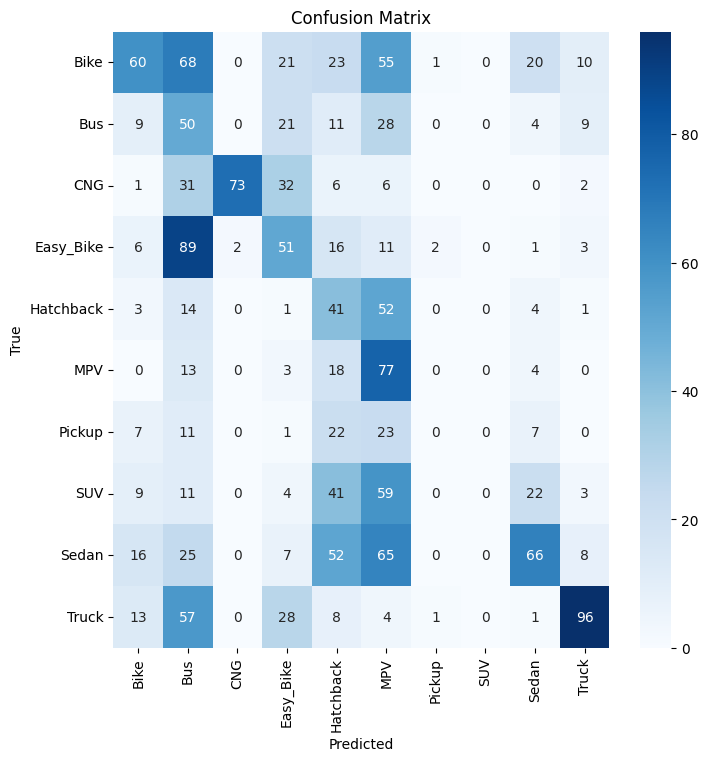

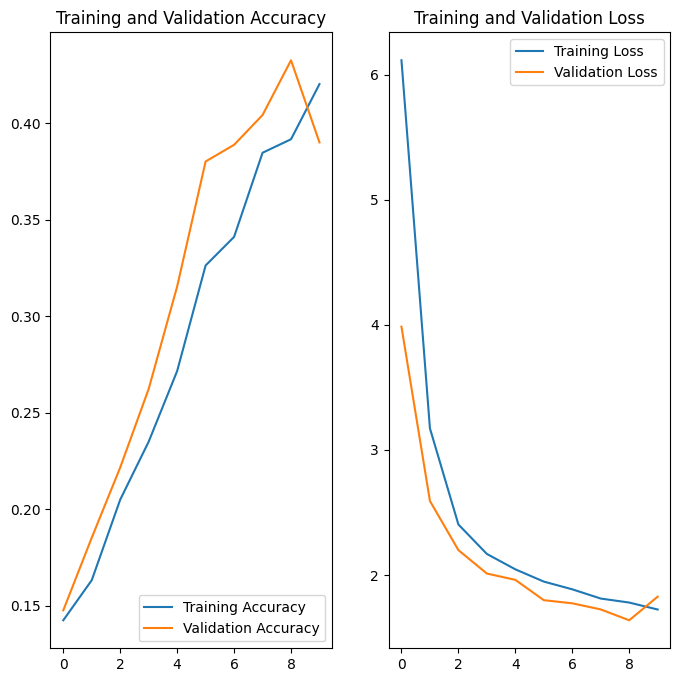

In [ ]:
#%%

import tensorflow as tf
import tf_keras
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tf_keras import layers
from tf_keras.models import Sequential
from sklearn.metrics import confusion_matrix
from tf_keras.optimizers import Adam
from tf_keras.regularizers import l2

tf.keras.backend.clear_session()

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
  tf.config.experimental.set_memory_growth(gpu_devices[0], True)
  print('GPU found', gpu_devices[0])
else:
  print('No GPU found')

#define image size
IMG_SIZE = 224

#define batch size
BATCH_SIZE = 64

#training directory
TRAINING_DIR = "Train"
  
#training split
train_ds = tf_keras.utils.image_dataset_from_directory(
  TRAINING_DIR,
  labels = "inferred",
  image_size = (IMG_SIZE, IMG_SIZE),
  batch_size = BATCH_SIZE,
  subset = "training",
  validation_split = 0.25,
  shuffle = True,
  seed = 225
)

#validation split, taken directly from the same directory as train
validation_ds = tf_keras.utils.image_dataset_from_directory(
  TRAINING_DIR,
  labels = "inferred",
  image_size = (IMG_SIZE, IMG_SIZE),
  batch_size = BATCH_SIZE,
  subset = 'validation',
  validation_split = 0.25,
  shuffle = True,
  seed = 225
)

CLASS_NAMES = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

#data augmentation to increase robustness
data_augmentation = Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2) 
])

#normalizing and augmenting the data
norm_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (norm_layer(data_augmentation(x)), y))
validation_ds = validation_ds.map(lambda x, y: (norm_layer(x), y))

num_classes = len(CLASS_NAMES)

#training model
model = Sequential([
  layers.Conv2D(64, (3, 3), input_shape = (224, 224, 3)),
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(64, (3, 3)),
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(128, (3, 3)),
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(128, (3, 3)),
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(256, (5, 5)), 
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(256, (3, 3)),
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Flatten(),
  layers.Dense(512, activation = 'relu', kernel_regularizer = l2(0.02)),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation = 'softmax')
])

model.summary()

model.compile(optimizer = Adam(learning_rate = 0.0005, weight_decay = 1e-6), 
              loss = tf_keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
              metrics = ['accuracy'])

#no of epochs
epochs = 10


#early stopping
early_stopping = tf_keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  mode = 'min', 
                                                  verbose = 1, 
                                                  patience = 3, 
                                                  restore_best_weights = True)

#class weights since the dataset is imbalanced
class_weights = {
    0: 0.657,  #bike
    1: 1.165,  #bus
    2: 1.006,  #cng
    3: 0.885,  #easy bike
    4: 1.385,  #hatchback
    5: 1.296,  #mpv
    6: 2.689,  #pickup
    7: 0.695,  #sedan
    8: 1.117,  #suv
    9: 0.770   #truck
}


#fitting of the model
history = model.fit(train_ds, 
                    validation_data = validation_ds, 
                    epochs = epochs,
                    class_weight = class_weights, 
                    callbacks = [early_stopping])

#accuracy and loss values
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

true_labels = []
predicted_labels = []

for images, labels in val_ds:
  true_labels.extend(labels.numpy())
  pred = model.predict(images)
  predicted_labels.extend(np.argmax(pred, axis = 1))

confusion_matrix = confusion_matrix(true_labels, predicted_labels)

print('Confusion Matrix: ')
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot = True, fmt = 'd', xticklabels = CLASS_NAMES, yticklabels = CLASS_NAMES, cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

score = model.evaluate(validation_ds, verbose = 0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

GPU found PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found 6480 files belonging to 10 classes.
Using 4860 files for training.
Found 6480 files belonging to 10 classes.
Using 1620 files for validation.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 activation (Activation)     (None, 222, 222, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 activation_1 (Activation)   

/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


60/76 [======================>.......] - ETA: 8s - loss: 6.5879 - accuracy: 0.1312

2025-01-20 00:40:34.098009: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


76/76 [==============================] - 58s 686ms/step - loss: 6.1154 - accuracy: 0.1354 - val_loss: 3.9802 - val_accuracy: 0.1475
Epoch 2/10
59/76 [======================>.......] - ETA: 8s - loss: 3.3386 - accuracy: 0.1356

2025-01-20 00:41:28.384081: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


76/76 [==============================] - 54s 654ms/step - loss: 3.2063 - accuracy: 0.1432 - val_loss: 2.6369 - val_accuracy: 0.1506
Epoch 3/10
60/76 [======================>.......] - ETA: 8s - loss: 2.4777 - accuracy: 0.1576

2025-01-20 00:42:24.649569: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


76/76 [==============================] - 55s 674ms/step - loss: 2.4272 - accuracy: 0.1718 - val_loss: 2.2486 - val_accuracy: 0.2043
Epoch 4/10
59/76 [======================>.......] - ETA: 9s - loss: 2.1495 - accuracy: 0.2617

2025-01-20 00:43:20.854199: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


76/76 [==============================] - 57s 689ms/step - loss: 2.1417 - accuracy: 0.2626 - val_loss: 1.9567 - val_accuracy: 0.3093
Epoch 5/10
59/76 [======================>.......] - ETA: 8s - loss: 1.9999 - accuracy: 0.3136

2025-01-20 00:44:16.652322: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


76/76 [==============================] - 55s 673ms/step - loss: 1.9915 - accuracy: 0.3148 - val_loss: 1.8443 - val_accuracy: 0.3512
Epoch 6/10
60/76 [======================>.......] - ETA: 9s - loss: 1.9281 - accuracy: 0.3500

2025-01-20 00:45:15.243359: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


76/76 [==============================] - 59s 720ms/step - loss: 1.9225 - accuracy: 0.3479 - val_loss: 1.7781 - val_accuracy: 0.3963
Epoch 7/10
59/76 [======================>.......] - ETA: 8s - loss: 1.8418 - accuracy: 0.3776

2025-01-20 00:46:11.371039: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


76/76 [==============================] - 56s 679ms/step - loss: 1.8330 - accuracy: 0.3798 - val_loss: 1.6995 - val_accuracy: 0.4074
Epoch 8/10
58/76 [=====================>........] - ETA: 9s - loss: 1.7785 - accuracy: 0.3955

2025-01-20 00:47:06.048889: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


76/76 [==============================] - 55s 660ms/step - loss: 1.7776 - accuracy: 0.3957 - val_loss: 1.6736 - val_accuracy: 0.4259
Epoch 9/10
58/76 [=====================>........] - ETA: 9s - loss: 1.7345 - accuracy: 0.4281 

2025-01-20 00:48:02.771255: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


76/76 [==============================] - 57s 701ms/step - loss: 1.7203 - accuracy: 0.4280 - val_loss: 1.5925 - val_accuracy: 0.4636
Epoch 10/10
59/76 [======================>.......] - ETA: 8s - loss: 1.7136 - accuracy: 0.4277

2025-01-20 00:48:59.022089: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


76/76 [==============================] - 56s 684ms/step - loss: 1.6991 - accuracy: 0.4327 - val_loss: 1.7226 - val_accuracy: 0.4216
Restoring model weights from the end of the best epoch: 9.
1/1 [==============================] - 0s 68ms/step
Confusion Matrix: 
Validation loss: 1.5925151109695435
Validation accuracy: 0.46358025074005127


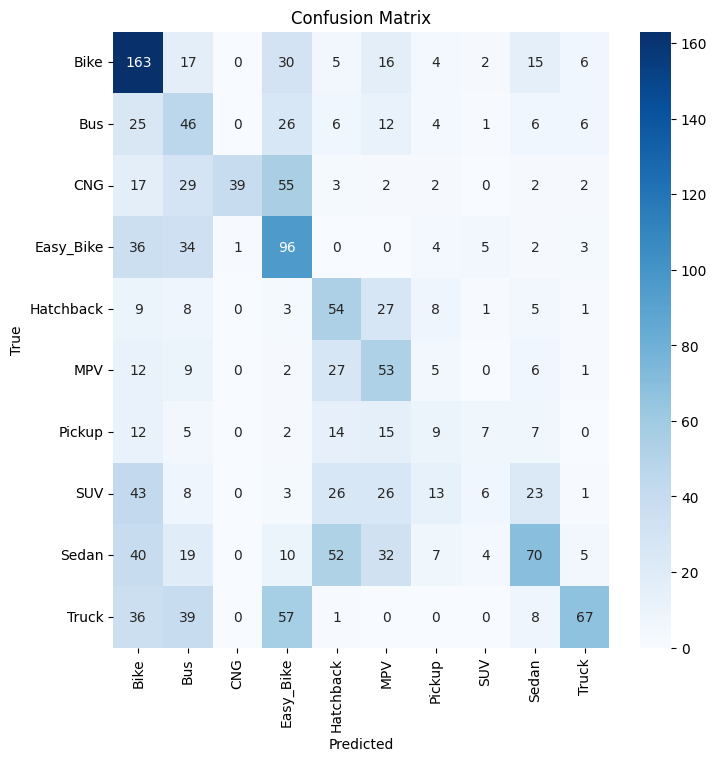

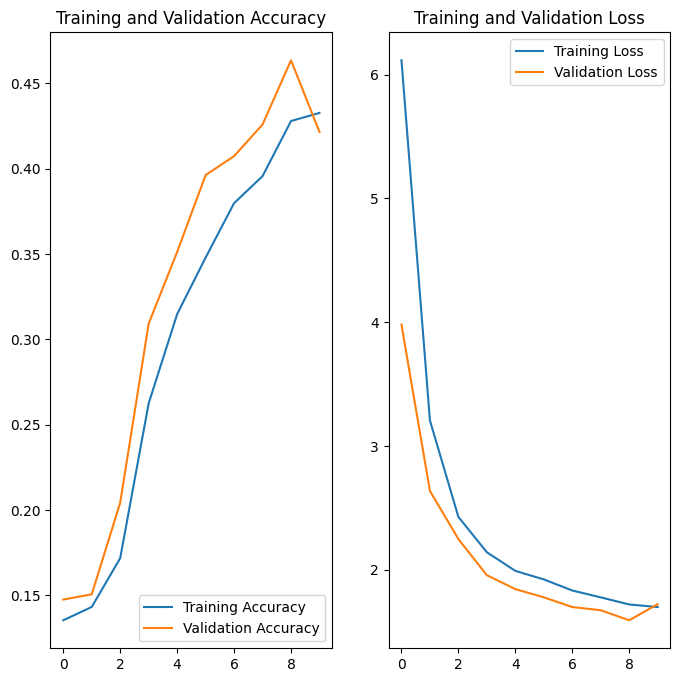

In [ ]:
#%%

import tensorflow as tf
import tf_keras
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tf_keras import layers
from tf_keras.models import Sequential
from sklearn.metrics import confusion_matrix
from tf_keras.optimizers import Adam
from tf_keras.regularizers import l2

tf.keras.backend.clear_session()

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
  tf.config.experimental.set_memory_growth(gpu_devices[0], True)
  print('GPU found', gpu_devices[0])
else:
  print('No GPU found')

#define image size
IMG_SIZE = 224

#define batch size
BATCH_SIZE = 64

#training directory
TRAINING_DIR = "Train"
  
#training split
train_ds = tf_keras.utils.image_dataset_from_directory(
  TRAINING_DIR,
  labels = "inferred",
  image_size = (IMG_SIZE, IMG_SIZE),
  batch_size = BATCH_SIZE,
  subset = "training",
  validation_split = 0.25,
  shuffle = True,
  seed = 225
)

#validation split, taken directly from the same directory as train
validation_ds = tf_keras.utils.image_dataset_from_directory(
  TRAINING_DIR,
  labels = "inferred",
  image_size = (IMG_SIZE, IMG_SIZE),
  batch_size = BATCH_SIZE,
  subset = 'validation',
  validation_split = 0.25,
  shuffle = True,
  seed = 225
)

CLASS_NAMES = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

#data augmentation to increase robustness
data_augmentation = Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2) 
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training = True), y))

#normalizing and augmenting the data
norm_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (norm_layer(x), y))
validation_ds = validation_ds.map(lambda x, y: (norm_layer(x), y))

num_classes = len(CLASS_NAMES)

#training model
model = Sequential([
  layers.Conv2D(64, (3, 3), input_shape = (224, 224, 3)),
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(64, (3, 3)),
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(128, (3, 3)),
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(128, (3, 3)),
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(256, (5, 5)), 
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(256, (3, 3)),
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Flatten(),
  layers.Dense(512, activation = 'relu', kernel_regularizer = l2(0.02)),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation = 'softmax')
])

model.summary()

model.compile(optimizer = Adam(learning_rate = 0.0005, weight_decay = 1e-6), 
              loss = tf_keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
              metrics = ['accuracy'])

#no of epochs
epochs = 10


#early stopping
early_stopping = tf_keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  mode = 'min', 
                                                  verbose = 1, 
                                                  patience = 3, 
                                                  restore_best_weights = True)

#class weights since the dataset is imbalanced
class_weights = {
    0: 0.657,  #bike
    1: 1.165,  #bus
    2: 1.006,  #cng
    3: 0.885,  #easy bike
    4: 1.385,  #hatchback
    5: 1.296,  #mpv
    6: 2.689,  #pickup
    7: 0.695,  #sedan
    8: 1.117,  #suv
    9: 0.770   #truck
}


#fitting of the model
history = model.fit(train_ds, 
                    validation_data = validation_ds, 
                    epochs = epochs,
                    class_weight = class_weights, 
                    callbacks = [early_stopping])

#accuracy and loss values
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

true_labels = []
predicted_labels = []

for images, labels in val_ds:
  true_labels.extend(labels.numpy())
  pred = model.predict(images)
  predicted_labels.extend(np.argmax(pred, axis = 1))

confusion_matrix = confusion_matrix(true_labels, predicted_labels)

print('Confusion Matrix: ')
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot = True, fmt = 'd', xticklabels = CLASS_NAMES, yticklabels = CLASS_NAMES, cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

score = model.evaluate(validation_ds, verbose = 0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()